In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import pickle
import netCDF4 as nc

from scipy.interpolate import griddata
from scipy.optimize import minimize_scalar


In [2]:
def calculate_eddy(width=500e3, num_depth_layers=21, eta0=1, L=1e5, H=1000,
                   a=1, b=1, rho0=1025, f0=None,
                   alpha_1=0.01, alpha_2=0.01,
                   T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None,
                   q11=1.0, q12=0.0, q22=1.0):
    """
    Compute 3D geostrophic U,V and fields for an eddy with prescribed
    quadratic-form shape coefficients q11,q12,q22 (constant in z).
    """
    if f0 is None:
        f0 = 2 * 7.29e-5 * np.sin(np.radians(-34))
    g = 9.81

    x = np.linspace(-width/2, width/2, 51)
    y = np.linspace(-width/2, width/2, 51)
    z = np.linspace(-H, 0, num_depth_layers)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    taper = np.exp(Z / taper_depth) if taper_depth is not None else 1.0

    # center shift with depth
    Xc = alpha_1 * Z
    Yc = alpha_2 * Z

    # elliptical radius-squared
    dX = X - Xc
    dY = Y - Yc
    r2Q = q11 * dX**2 + 2*q12 * dX * dY + q22 * dY**2

    phi = np.exp(-r2Q / L**2) * taper

    T = -2 * phi
    S = 1.5 * phi
    P = -rho0 * g * Z

    alpha = 2e-4
    beta  = 8e-4
    sigma = rho0 * (1 - alpha*(T - T0) + beta*(S - 35))
    sigma -= sigma.mean()

    dx, dy = x[1]-x[0], y[1]-y[0]
    dsdx = np.gradient(sigma, dx, axis=0)
    dsdy = np.gradient(sigma, dy, axis=1)

    U =  g/f0 * dsdy * taper
    V = -g/f0 * dsdx * taper

    # flip so z=0 is first index
    U, V, sigma, T, S, P = [np.flip(arr, axis=2) for arr in (U,V,sigma,T,S,P)]
    z = z[::-1]

    # transpose horizontal slices
    for k in range(U.shape[2]):
        U[:,:,k] = U[:,:,k].T
        V[:,:,k] = V[:,:,k].T

    return U, V, sigma, T, S, P, x/1000, y/1000, z/1000


In [3]:
def dopioe(x1, y1, u1, v1, x2, y2, u2, v2):
    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]
    
    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    if np.any(np.isnan(u1)) or np.any(np.isnan(u2)):
        return np.nan, np.nan, np.nan, np.nan

    points1 = set(zip(x1, y1))
    points2 = set(zip(x2, y2))
    common_points = points1 & points2
    
    if len(common_points) != 1:
        print(f"Warning: Expected 1 common point, found {len(common_points)}.")
        return np.nan, np.nan, np.nan, np.nan
    
    center_x, center_y = next(iter(common_points))

    xx = x1 - center_x
    yy = y2 - center_y

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q
    

In [4]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400)
X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
dx


np.float64(10.0)

-0.018747026280112506 7.401400862036035e-06 -0.018747026280112506


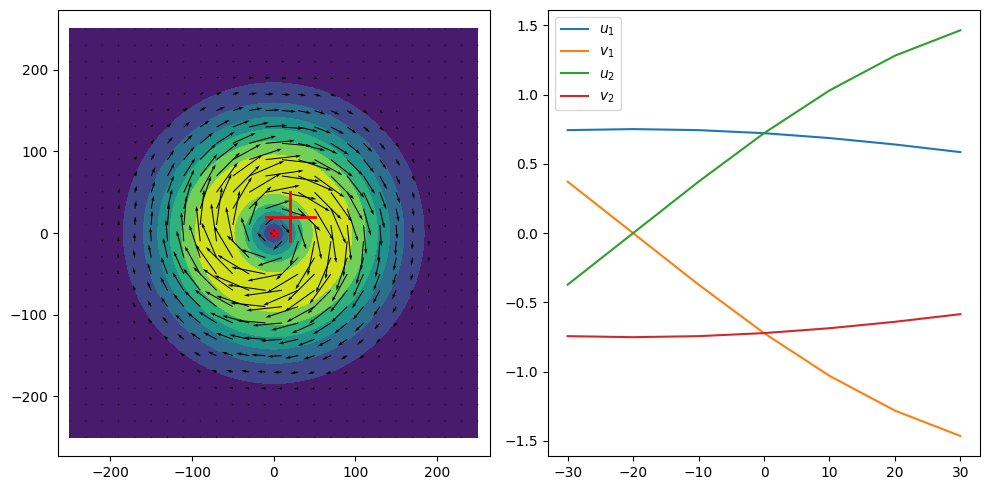

In [5]:
k = 0
u, v = U[:,:,k], V[:,:,k]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].contourf(X, Y, np.hypot(u, v))
spacing = 2
axs[0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], u[::spacing, ::spacing], v[::spacing, ::spacing])
axs[0].axis('equal')

ic, jc, rc = X.shape[0]//2 + 2, X.shape[1]//2 + 2, 3

u1 = u.T[ic - rc: ic + rc + 1, jc]
v1 = v.T[ic - rc: ic + rc + 1, jc]
x1 = X.T[ic - rc: ic + rc + 1, jc]
y1 = Y.T[ic - rc: ic + rc + 1, jc]
u2 = u.T[ic, jc - rc: jc + rc + 1]
v2 = v.T[ic, jc - rc: jc + rc + 1]
x2 = X.T[ic, jc - rc: jc + rc + 1]
y2 = Y.T[ic, jc - rc: jc + rc + 1]

x0, y0, w, Q = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
q11, q12, q22 = Q[0,0], Q[1,0], Q[1,1]
print(q11, q12, q22)

q11, q22 = np.abs(q11), np.abs(q22)

axs[0].scatter(x0, y0, marker='x', color='r')

points1 = set(zip(x1, y1))
points2 = set(zip(x2, y2))
common_points = points1 & points2
center_x, center_y = next(iter(common_points))
xx = x1 - center_x
yy = y2 - center_y

axs[0].plot(x1, y1, 'r', linewidth=2)
axs[0].plot(x2, y2, 'r', linewidth=2)

axs[1].plot(xx, u1, label=r'$u_1$')
axs[1].plot(xx, v1, label=r'$v_1$')
axs[1].plot(yy, u2, label=r'$u_2$')
axs[1].plot(yy, v2, label=r'$v_2$')
axs[1].legend()

plt.tight_layout()
plt.show()


## Eddy Velocity Field Retrieval

We define an **elliptical Gaussian eddy** using a streamfunction

$$
\psi(x, y) = \exp\left(-\frac{1}{R^2} \phi(x, y)\right)
$$

where the scalar field $\phi$ is quadratic in $x$ and $y$

$$
\phi(x, y) = q_{11}(x - x_0)^2 + 2q_{12}(x - x_0)(y - y_0) + q_{22}(y - y_0)^2.
$$

This gives an elliptical shape controlled by the symmetric matrix $Q$

$$
Q = \begin{bmatrix}
q_{11} & q_{12} \\
q_{12} & q_{22}
\end{bmatrix}.
$$

The geostrophic velocity field is derived from the streamfunction via

$$
u = -\frac{\partial \psi}{\partial y}, \quad v = \frac{\partial \psi}{\partial x}.
$$

We compute the gradients using the chain rule

$$
\frac{\partial \psi}{\partial x} = -\frac{1}{R^2} \frac{\partial \phi}{\partial x} \exp\left(-\frac{1}{R^2} \phi\right), \quad
\frac{\partial \psi}{\partial y} = -\frac{1}{R^2} \frac{\partial \phi}{\partial y} \exp\left(-\frac{1}{R^2} \phi\right)
$$

with

$$
\frac{\partial \phi}{\partial x} = 2q_{11}(x - x_0) + 2q_{12}(y - y_0),
$$
$$
\frac{\partial \phi}{\partial y} = 2q_{22}(y - y_0) + 2q_{12}(x - x_0).
$$
Lets look at the normal velocity along the horizontal transect $y=y_T$, where $y_T$ is the $y$ position of the transect
$$ 
V_{N_1} = -\frac{1}{R_c^2}\left[2q_{11}(x-x_0)+2q_{12}(y_T-y_0)\right]\exp\left\{-\frac{1}{R_c^2}\left[q_{11}(x-x_0)^2+2q_{12}(x-x_0)(y_T-y_0)+q_{22}(y_T-y_0)^2\right]\right\}
$$
$$
V_{N_1} = -\frac{1}{R_c^2}(Ax+B)\exp\left\{-\frac{1}{R_c^2}(Cx^2+Dx+E)\right\}
$$
where
$$
A=2C=2q_{11}, \quad B=D=-2q_{11}x_0+2q_{12}(y_T-y_0), \quad E=q_{11}x_0^2-2q_{12}x_0(y_T-y_0)+q_{22}(y_T-y_0)^2
$$
so
$$
V_{N_1} = -\frac{1}{R_c^2}(2Cx+B)\exp\left\{-\frac{1}{R_c^2}(Cx^2+Bx+E)\right\}.
$$
Similarly
$$
V_{T_1} = -\frac{1}{R_c^2}(Fx+G)\exp\left\{-\frac{1}{R_c^2}(Cx^2+Dx+E)\right\}
$$
where 
$$
F=-2q_{12}, \quad G=2q_{12}x_0-2q_{22}(y_T-y_0),
$$
$$
C=q_{11}, \quad D=-2q_{11}x_0+2q_{12}(y_T-y_0), \quad E=q_{11}x_0^2-2q_{12}x_0(y_T-y_0)+q_{22}(y_T-y_0)^2.
$$

$$
\boxed{%
  \begin{aligned}
    V_{N_1} &= -\frac{1}{R_c^2}(2Cx+B)\exp\left\{-\frac{1}{R_c^2}(Cx^2+Bx+E)\right\},
    \\
    V_{T_1} &= -\frac{1}{R_c^2}(Fx+G)\exp\left\{-\frac{1}{R_c^2}(Cx^2+Dx+E)\right\},
    \\
    C &= q_{11},
    \\
    D &= B = -2q_{11}x_0+2q_{12}(y_T-y_0),
    \\
    E &= q_{11}x_0^2-2q_{12}x_0(y_T-y_0)+q_{22}(y_T-y_0)^2,
    \\
    F &= -2q_{12},
    \\
    G &= 2q_{12}x_0-2q_{22}(y_T-y_0).
  \end{aligned}
}
$$

In [9]:
def fit_Rc_VN1(x1, y1, v1, q11, q12, q22, x0, y0,
           scale0=1.0, Rc0=1.0,
           bounds_scale=(-np.inf, np.inf), bounds_Rc=(1e-6, 15)):
    from scipy.optimize import minimize

    q11, q22 = np.abs(q11), np.abs(q22)

    # relative transect offset
    y_T = y1[0]

    def obj(p):
        scale, Rc = p
        if Rc <= 0:
            return np.inf

        # build un‐scaled quadratic
        C = q11
        B = -2*q11*x0 + 2*q12*(y_T-y0)
        E = q11*x0**2 - 2*q12*x0*(y_T-y0) + q22*(y_T-y0)**2

        # modelled V_N
        expo = -(C*x1**2 + B*x1 + E) / Rc**2
        VN = -(2*C*x1 + B) / Rc**2 * np.exp(expo) * scale

        return np.sum((v1 - VN)**2)

    p0 = np.array([scale0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_scale, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # scale_opt, Rc_opt

scale_VN1, Rc_VN1 = fit_Rc_VN1(x1, y1, v1, q11, q12, q22, x0, y0)
print("Optimal Rc =", Rc_VN1)
print("Optimal Scale =", scale_VN1)


Optimal Rc = 15.0
Optimal Scale = 1e-06


$$
\boxed{%
  \begin{aligned}
    V_{N_1} &= -\frac{1}{R_c^2}(2Cx+B)\exp\left\{-\frac{1}{R_c^2}(Cx^2+Bx+E)\right\},
    \\
    V_{T_1} &= -\frac{1}{R_c^2}(Fx+G)\exp\left\{-\frac{1}{R_c^2}(Cx^2+Dx+E)\right\},
    \\
    C &= q_{11},
    \\
    D &= B = -2q_{11}x_0+2q_{12}(y_T-y_0),
    \\
    E &= q_{11}x_0^2-2q_{12}x_0(y_T-y_0)+q_{22}(y_T-y_0)^2,
    \\
    F &= -2q_{12},
    \\
    G &= 2q_{12}x_0-2q_{22}(y_T-y_0).
  \end{aligned}
}
$$

In [7]:
def fit_Rc_VT1(x1, y1, u1, q11, q12, q22, x0, y0,
           scale0=1.0, Rc0=1.0,
           bounds_scale=(-np.inf, np.inf), bounds_Rc=(1e-6, 15)):
    from scipy.optimize import minimize

    q11, q22 = np.abs(q11), np.abs(q22)

    # relative transect offset
    y_T = y1[0]

    def obj(p):
        scale, Rc = p
        if Rc <= 0:
            return np.inf

        # build un‐scaled quadratic
        F = -2*q12
        G = 2*q12*x0 - 2*q22*(y_T-y0)
        C = q11
        D = -2*q11*x0 + 2*q12*(y_T-y0)
        E = q11*x0**2 - 2*q12*x0*(y_T-y0) + q22*(y_T-y0)**2

        # modelled V_N
        expo = -(C*x1**2 + D*x1 + E) / Rc**2
        VT = -(F*x1 + G) / Rc**2 * np.exp(expo) * scale

        return np.sum((u1 - VT)**2)

    p0 = np.array([scale0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_scale, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # scale_opt, Rc_opt

scale_VT1, Rc_VT1 = fit_Rc_VT1(x1, y1, u1, q11, q12, q22, x0, y0)
print("Optimal Rc =", Rc_VT1)
print("Optimal Scale =", scale_VT1)


Optimal Rc = 13.681074349980697
Optimal Scale = 194.6271824043923


Now for the vertical transect, i.e. at $x=x_T$
$$
V_{N_2}=-\frac{1}{Rc^2}\left[-2q_{22}(y-y_0)-2q_{12}(x_T-x_0)\right]\exp\left\{-\frac{1}{Rc^2}\left[q_{11}(x_T-x_0)^2+2q_{12}(x_T-x_0)(y-y_0)+q_{22}(y-y_0)^2\right]\right\}
$$
$$
V_{N_2} = -\frac{1}{R_c^2}(Ay+B)\exp\left\{-\frac{1}{R_c^2}(Cy^2+Dy+E)\right\}
$$
where
$$
A=-2C=-2q_{22}, \quad D=-B=2q_{12}(x_T-x_0)-2y_0q_{22}, \quad E=q_{11}(x_T-x_0)^2-2q_{12}(x_T-x_0)y_0+q_{22}y_0^2
$$
so
$$
V_{N_2} = -\frac{1}{R_c^2}(-2Cy+B)\exp\left\{-\frac{1}{R_c^2}(Cy^2-By+E)\right\}
$$

similarly
$$
V_{T_2}=-\frac{1}{Rc^2}\left[2q_{11}(x_T - x_0) + 2q_{12}(y - y_0)\right]\exp\left\{-\frac{1}{Rc^2}\left[q_{11}(x_T-x_0)^2+2q_{12}(x_T-x_0)(y-y_0)+q_{22}(y-y_0)^2\right]\right\}
$$
$$
V_{T_2} = -\frac{1}{R_c^2}(Fy+G)\exp\left\{-\frac{1}{R_c^2}(Cy^2+Dy+E)\right\}
$$
with
$$
F=2q_{12}, \quad G=2q_{11}(x_T-x_0)-2q_{12}y_0
$$



$$
\boxed{%
  \begin{aligned}
    V_{N_2} &= -\frac{1}{R_c^2}(-2Cy+B)\exp\left\{-\frac{1}{R_c^2}(Cy^2-By+E)\right\},
    \\
    V_{T_2} &= -\frac{1}{R_c^2}(Fy+G)\exp\left\{-\frac{1}{R_c^2}(Cy^2+Dy+E)\right\},
    \\
    C &= q_{22},
    \\
    D &=-B=2q_{12}(x_T-x_0)-2y_0q_{22},
    \\
    E &=q_{11}(x_T-x_0)^2-2q_{12}(x_T-x_0)y_0+q_{22}y_0^2,
    \\
    F &= 2q_{12},
    \\
    G &= 2q_{11}(x_T-x_0)-2q_{12}y_0.
  \end{aligned}
}
$$

In [8]:
def fit_Rc_VN2(x2, y2, u2, q11, q12, q22, x0, y0,
           scale0=1.0, Rc0=1.0,
           bounds_scale=(-np.inf, np.inf), bounds_Rc=(1e-6, 15)):
    from scipy.optimize import minimize

    q11, q22 = np.abs(q11), np.abs(q22)

    # relative transect offset
    x_T = x2[0]

    def obj(p):
        scale, Rc = p
        if Rc <= 0:
            return np.inf

        # build un‐scaled quadratic
        C = q22
        B = 2*y0*q22 - 2*q12*(x_T-x0)
        E = q11*(x_T-x0)**2 - 2*q12*(x_T-x0)*y0 + q22*y0**2

        # modelled V_N
        expo = -(C*y2**2 - B*y2 + E) / Rc**2
        VN = -(-2*C*y2 + B) / Rc**2 * np.exp(expo) * scale

        return np.sum((u2 - VN)**2)

    p0 = np.array([scale0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_scale, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # scale_opt, Rc_opt

scale_VN2, Rc_VN2 = fit_Rc_VN2(x2, y2, u2, q11, q12, q22, x0, y0)
print("Optimal Rc =", Rc_VN2)
print("Optimal Scale =", scale_VN2)


Optimal Rc = 13.776813567060547
Optimal Scale = 197.33482794836647


$$
\boxed{%
  \begin{aligned}
    V_{N_2} &= -\frac{1}{R_c^2}(-2Cy+B)\exp\left\{-\frac{1}{R_c^2}(Cy^2-By+E)\right\},
    \\
    V_{T_2} &= -\frac{1}{R_c^2}(Fy+G)\exp\left\{-\frac{1}{R_c^2}(Cy^2+Dy+E)\right\},
    \\
    C &= q_{22},
    \\
    D &=-B=2q_{12}(x_T-x_0)-2y_0q_{22},
    \\
    E &=q_{11}(x_T-x_0)^2-2q_{12}(x_T-x_0)y_0+q_{22}y_0^2,
    \\
    F &= 2q_{12},
    \\
    G &= 2q_{11}(x_T-x_0)-2q_{12}y_0.
  \end{aligned}
}
$$

In [9]:
def fit_Rc_VT2(x2, y2, v2, q11, q12, q22, x0, y0,
           scale0=1.0, Rc0=1.0,
           bounds_scale=(-np.inf, np.inf), bounds_Rc=(1e-6, 15)):
    from scipy.optimize import minimize

    q11, q22 = np.abs(q11), np.abs(q22)

    # relative transect offset
    x_T = x2[0]

    def obj(p):
        scale, Rc = p
        if Rc <= 0:
            return np.inf

        # build un‐scaled quadratic
        F = 2*q12
        G = 2*q11*(x_T-x0) - 2*q12*y0
        C = q22
        D = 2*q12*(x_T-x0) - 2*y0*q22
        E = q11*(x_T-x0)**2 - 2*q12*(x_T-x0)*y0 + q22*y0**2

        # modelled V_N
        expo = -(C*y2**2 + D*y2 + E) / Rc**2
        VT = -(F*y2 + G) / Rc**2 * np.exp(expo) * scale

        return np.sum((v2 - VT)**2)

    p0 = np.array([scale0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_scale, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # scale_opt, Rc_opt

scale_VT2, Rc_VT2 = fit_Rc_VT2(x2, y2, v2, q11, q12, q22, x0, y0)
print("Optimal Rc =", Rc_VT2)
print("Optimal Scale =", scale_VT2)


Optimal Rc = 13.681074349980697
Optimal Scale = 194.6271824043923


In [10]:
df_Rc = pd.DataFrame({'Rc': [Rc_VN1, Rc_VT1, Rc_VN2, Rc_VT2], 'Scale': [scale_VN1, scale_VT1, scale_VN2, scale_VT2]})
df_Rc.index = [r'$V_{N1}$', r'$V_{T1}$', r'$V_{N2}$', r'$V_{T2}$']
Rc = df_Rc[df_Rc['Rc']!=1]['Rc'].median()
print(df_Rc['Scale'].mean())
df_Rc


195.9810051763794


,Rc,Scale
$V_{N1}$,13.776814,197.334828
$V_{T1}$,13.681074,194.627182
$V_{N2}$,13.776814,197.334828
$V_{T2}$,13.681074,194.627182


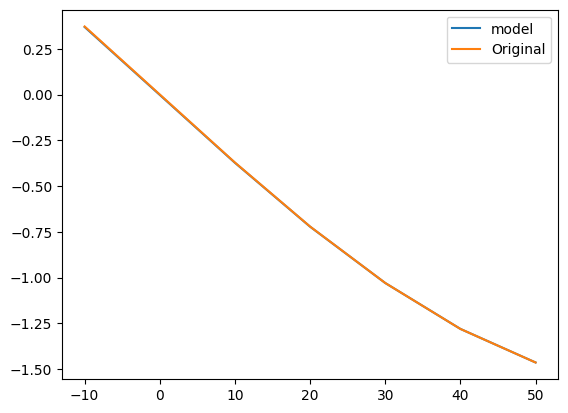

In [11]:
y_T = y1[0]
C = q11
B = -2*q11*x0 + 2*q12*(y_T-y0)
E = q11*x0**2 - 2*q12*x0*(y_T-y0) + q22*(y_T-y0)**2

# modelled V_N
expo = -(C*x1**2 + B*x1 + E) / Rc_VN1**2
VN = -(2*C*x1 + B) / Rc_VN1**2 * np.exp(expo) * scale_VN1

plt.plot(x1, VN, label='model')
plt.plot(x1, v1, label='Original')
plt.legend()


#### Reconstruct

In [12]:
def gaussian_vel_reconstruction(x0, y0, q11, q12, q22, R):

    q11, q22 = np.abs(q11), np.abs(q22)
    
    width = 200
    x = np.linspace(x0-width, x0+width, 51)
    y = np.linspace(y0-width, y0+width, 51)
    X, Y = np.meshgrid(x, y)
    
    dx, dy = X - x0, Y - y0
    
    phi   = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
    phi_x = 2*q11*dx  + 2*q12*dy
    phi_y = 2*q22*dy  + 2*q12*dx
    
    # 5) build Gaussian streamfunction with that R
    exp_term = np.exp(-phi / R**2)
    psi_x = -phi_x / R**2 * exp_term
    psi_y = -phi_y / R**2 * exp_term
    
    u = -psi_y 
    v =  psi_x 

    return u, v, X, Y

u_new, v_new, X_new, Y_new = gaussian_vel_reconstruction(x0, y0, q11, q12, q22, Rc)

def vel_scalar(x1, y1, u1, v1, x2, y2, u2, v2, u, v, X, Y):
    points = np.column_stack((X.ravel(), Y.ravel()))
    values_v, values_u = v.ravel(), u.ravel()
    
    # Query at new points
    v1_psi = griddata(points, values_v, (x1, y1), method='linear')
    u1_psi = griddata(points, values_u, (x1, y1), method='linear')
    v2_psi = griddata(points, values_v, (x2, y2), method='linear')
    u2_psi = griddata(points, values_u, (x2, y2), method='linear')
    
    def objective(scale):
        return np.sum((u1 - u1_psi * scale)**2 + (v1 - v1_psi * scale)**2) + np.sum((u2 - u2_psi * scale)**2 + (v2 - v2_psi * scale)**2)
    
    res = minimize_scalar(objective)
    scale_opt = res.x
    
    u *= scale_opt
    v *= scale_opt

    v1_psi *= scale_opt
    u1_psi *= scale_opt
    v2_psi *= scale_opt
    u2_psi *= scale_opt

    print(f'Optimal Scale = {scale_opt}')
    
    return u, v, u1_psi, v1_psi, u2_psi, v2_psi

u_new, v_new, u1_psi, v1_psi, u2_psi, v2_psi = vel_scalar(x1, y1, u1, v1, x2, y2, u2, v2, u_new, v_new, X_new, Y_new)


Optimal Scale = 197.0571040338541


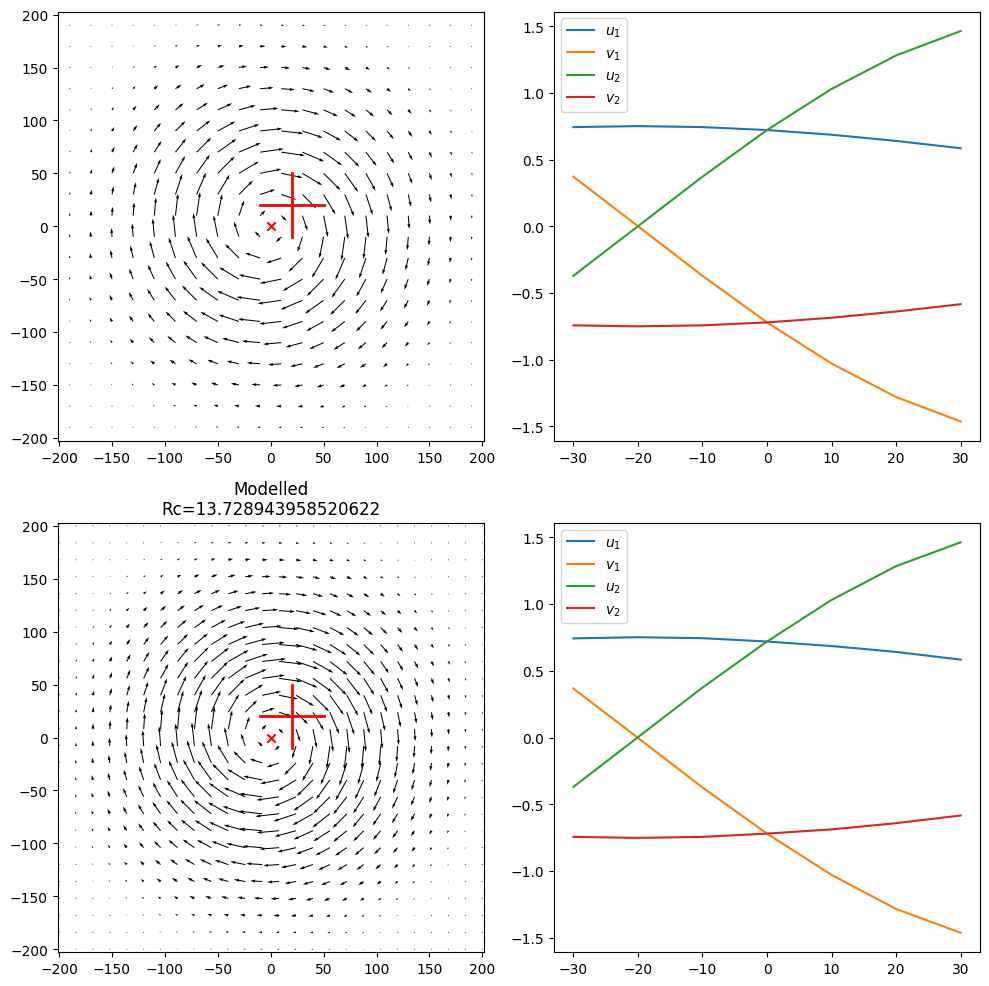

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
quiv_scale = 30

spacing = 2
axs[0,0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
           u[::spacing, ::spacing], v[::spacing, ::spacing], scale=quiv_scale)
axs[0,0].scatter(x0, y0, marker='x', color='r')

axs[0,0].plot(x1, y1, color='r', linewidth=2, zorder=1)
axs[0,0].plot(x2, y2, color='r', linewidth=2, zorder=1)

axs[0,0].axis('equal')
axs[0,0].set_xlim(-200, 200)
axs[0,0].set_ylim(-200, 200)

axs[0,1].plot(xx, u1, label=r'$u_1$')
axs[0,1].plot(xx, v1, label=r'$v_1$')
axs[0,1].plot(yy, u2, label=r'$u_2$')
axs[0,1].plot(yy, v2, label=r'$v_2$')
axs[0,1].legend()

# axs[1,0].pcolor(X_new, Y_new, np.hypot(u_new, v_new))
# axs[1,0].colorbar()
spacing = 2
axs[1,0].quiver(X_new[::spacing, ::spacing], Y_new[::spacing, ::spacing],
           u_new[::spacing, ::spacing], v_new[::spacing, ::spacing], scale=quiv_scale)

axs[1,0].plot(x1, y1, color='r', linewidth=2, zorder=1)
axs[1,0].plot(x2, y2, color='r', linewidth=2, zorder=1)
axs[1,0].scatter(x0, y0, marker='x', color='r')
axs[1,0].set_title(f'Modelled\nRc={Rc}')

axs[1,0].axis('equal')
axs[1,0].set_xlim(-200, 200)
axs[1,0].set_ylim(-200, 200)

axs[1,1].plot(xx, u1_psi, label=r'$u_1$')
axs[1,1].plot(xx, v1_psi, label=r'$v_1$')
axs[1,1].plot(yy, u2_psi, label=r'$u_2$')
axs[1,1].plot(yy, v2_psi, label=r'$v_2$')
axs[1,1].legend()

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'CS Error')

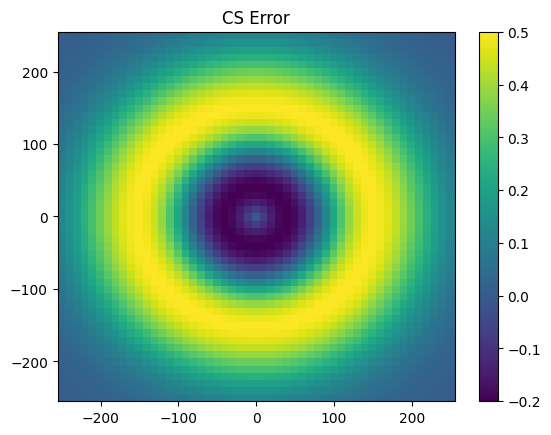

In [14]:
plt.pcolor(X, Y, np.hypot(u_new, v_new)-np.hypot(u, v))
plt.colorbar()
plt.title('CS Error')


## ROMS

In [15]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = list(dic_sample.keys())

df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


In [16]:
sample_eddies

['Eddy2749',
 'Eddy8',
 'Eddy2504',
 'Eddy896',
 'Eddy1394',
 'Eddy382',
 'Eddy1967',
 'Eddy926']

In [17]:
eddy = sample_eddies[6]
dic = dic_sample[eddy]
day = list(dic.keys())[10]
df_snapshot = dic[day]

fname = df_eddies[(df_eddies['ID']==int(eddy[4:]))&(df_eddies['Day']==int(day[3:]))].iloc[0]['fname']
fnumber = fname[-8:-3]
u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
u_raw = np.where(u_raw > 1e30, np.nan, u_raw).astype(float)
v_raw = np.where(v_raw > 1e30, np.nan, v_raw).astype(float)
with nc.Dataset(fname) as dataset:
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
t_rel = np.where(ocean_time == int(day[3:]))[0][0]

k = 0
data = df_snapshot.iloc[k]
x0, y0, Q, w, depth = data.x, data.y, data.Q, data.w, data.Depth
q11, q12, q22 = Q[0,0], Q[1,0], Q[1,1]
print(q11, q12, q22)

u, v = u_raw[:, :, k, t_rel], v_raw[:, :, k, t_rel]
u = np.where(mask_rho, u, np.nan)
v = np.where(mask_rho, v, np.nan)

# Extract Eddy Domain
mask = np.hypot(X_grid - x0, Y_grid - y0) <= 200
i_mask, j_mask = np.where(mask)
i_mask = np.arange(i_mask.min(), i_mask.max() + 1)
j_mask = np.arange(j_mask.min(), j_mask.max() + 1)
i_mask, j_mask = np.meshgrid(i_mask, j_mask)
i_mask, j_mask = i_mask.flatten(), j_mask.flatten()

i_min, j_min = i_mask.min(), j_mask.min()
i_range, j_range = i_mask.max() - i_min + 1, j_mask.max() - j_min + 1

u_eddy_domain = np.zeros((i_range, j_range))
v_eddy_domain = np.zeros((i_range, j_range))
X_eddy_domain = np.zeros((i_range, j_range))
Y_eddy_domain = np.zeros((i_range, j_range))
x_eddy_domain, y_eddy_domain = X_eddy_domain[:,0], Y_eddy_domain[0,:]

for i, j in zip(i_mask, j_mask):
    u_eddy_domain[i - i_min, j - j_min] = u[i, j]
    v_eddy_domain[i - i_min, j - j_min] = v[i, j]
    X_eddy_domain[i - i_min, j - j_min] = X_grid[i, j]
    Y_eddy_domain[i - i_min, j - j_min] = Y_grid[i, j]


-0.008418143656544594 -0.000479935766615009 -0.007305326419901507


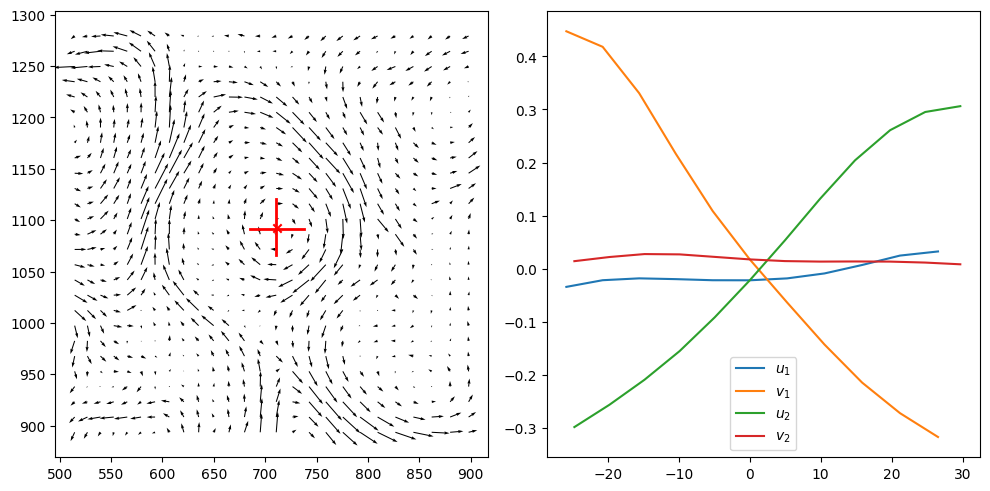

In [18]:
r = 30

dis = np.hypot(X_eddy_domain - x0, Y_eddy_domain - y0)
ic, jc = np.where(dis == np.min(dis))

x_mask = np.abs(x_eddy_domain - x0) < r
x1 = x_eddy_domain[x_mask]
y1 = np.full_like(x1, y_eddy_domain[jc])
u1 = u_eddy_domain[x_mask, jc]
v1 = v_eddy_domain[x_mask, jc]

y_mask = np.abs(y_eddy_domain - y0) < r
y2 = y_eddy_domain[y_mask]
x2 = np.full_like(y2, x_eddy_domain[ic])
u2 = u_eddy_domain[ic, y_mask]
v2 = v_eddy_domain[ic, y_mask]

points1 = set(map(tuple, zip(x1.ravel(), y1.ravel())))
points2 = set(map(tuple, zip(x2.ravel(), y2.ravel())))
common_points = points1 & points2

if not common_points:
    raise ValueError("No common points found.")

center_x, center_y = next(iter(common_points))
xx = x1 - center_x
yy = y2 - center_y

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

spacing = 3
axs[0].quiver(X_eddy_domain[::spacing, ::spacing], Y_eddy_domain[::spacing, ::spacing],
           u_eddy_domain[::spacing, ::spacing], v_eddy_domain[::spacing, ::spacing])
axs[0].scatter(x0, y0, marker='x', color='r')
axs[0].axis('equal')

axs[0].plot(x1, y1, color='r', linewidth=2, zorder=1)
axs[0].plot(x2, y2, color='r', linewidth=2, zorder=1)

axs[1].plot(xx, u1, label=r'$u_1$')
axs[1].plot(xx, v1, label=r'$v_1$')
axs[1].plot(yy, u2, label=r'$u_2$')
axs[1].plot(yy, v2, label=r'$v_2$')
axs[1].legend()

plt.tight_layout()
plt.show()


In [19]:
scale_VN1, Rc_VN1 = fit_Rc_VN1(x1, y1, v1, q11, q12, q22, x0, y0)
scale_VT1, Rc_VT1 = fit_Rc_VT1(x1, y1, u1, q11, q12, q22, x0, y0)

scale_VN2, Rc_VN2 = fit_Rc_VN2(x2, y2, u2, q11, q12, q22, x0, y0)
scale_VT2, Rc_VT2 = fit_Rc_VT2(x2, y2, v2, q11, q12, q22, x0, y0)

df_Rc = pd.DataFrame({'Rc': [Rc_VN1, Rc_VT1, Rc_VN2, Rc_VT2], 'Scale': [scale_VN1, scale_VT1, scale_VN2, scale_VT2]})
df_Rc.index = [r'$V_{N1}$', r'$V_{T1}$', r'$V_{N2}$', r'$V_{T2}$']
Rc = df_Rc['Rc'].median()

print("Optimal Rc =", Rc)
print("Optimal Scale =", df_Rc['Scale'].min())
df_Rc


Optimal Rc = 2.8788442387353443
Optimal Scale = 0.8100442662197201


,Rc,Scale
$V_{N1}$,5.997696,38.022598
$V_{T1}$,0.772405,0.810044
$V_{N2}$,4.111775,17.840062
$V_{T2}$,1.645914,2.664286


In [20]:
u, v, X, Y = gaussian_vel_reconstruction(x0, y0, q11, q12, q22, Rc)

u, v, u1_psi, v1_psi, u2_psi, v2_psi = vel_scalar(x1, y1, u1, v1, x2, y2, u2, v2, u, v, X, Y)


Optimal Scale = 11.691152021480722


In [21]:
X_eddy_domain[1,0]-X_eddy_domain[0,0]

np.float64(4.120441598916727)

In [22]:
X[0,1]-X[0,0]

np.float64(8.0)

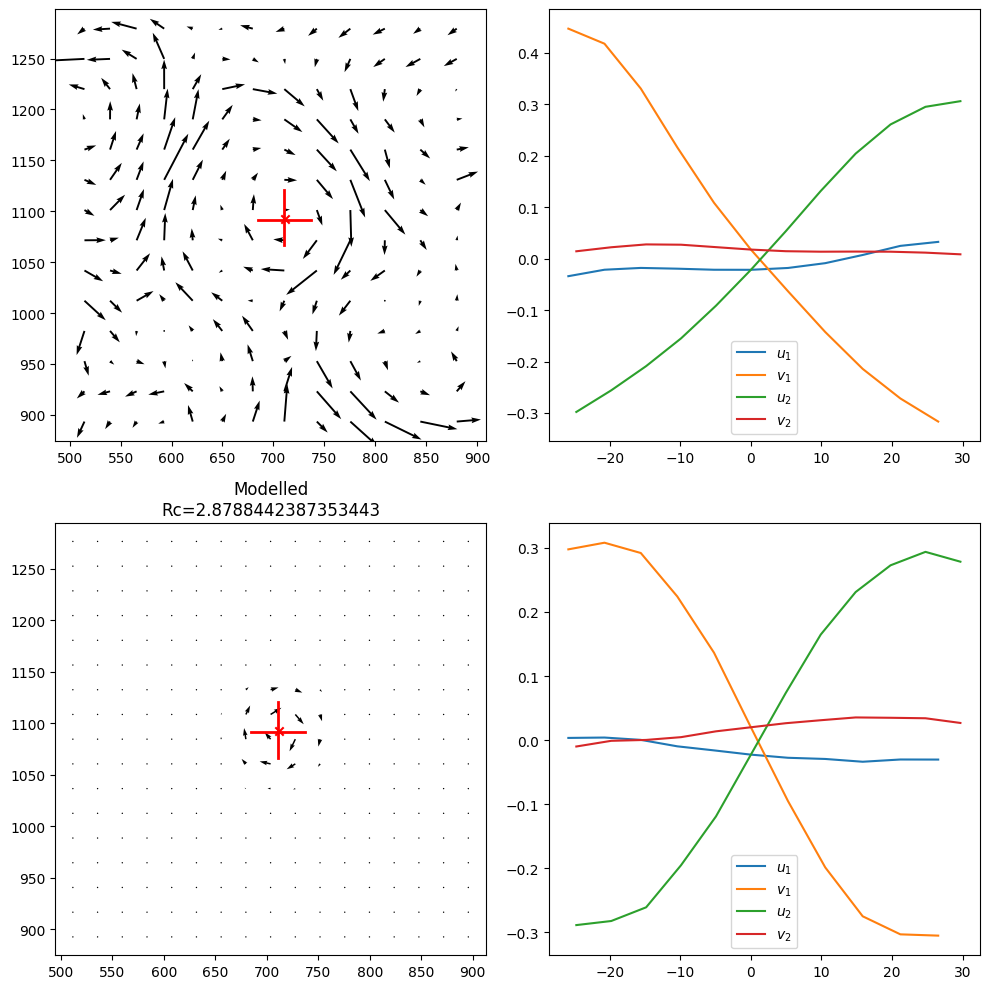

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
quiv_scale = 10

spacing = 6
axs[0,0].quiver(X_eddy_domain[::spacing, ::spacing], Y_eddy_domain[::spacing, ::spacing],
           u_eddy_domain[::spacing, ::spacing], v_eddy_domain[::spacing, ::spacing], scale=quiv_scale)
axs[0,0].scatter(x0, y0, marker='x', color='r')
axs[0,0].axis('equal')

axs[0,0].plot(x1, y1, color='r', linewidth=2, zorder=1)
axs[0,0].plot(x2, y2, color='r', linewidth=2, zorder=1)

axs[0,1].plot(xx, u1, label=r'$u_1$')
axs[0,1].plot(xx, v1, label=r'$v_1$')
axs[0,1].plot(yy, u2, label=r'$u_2$')
axs[0,1].plot(yy, v2, label=r'$v_2$')
axs[0,1].legend()

# axs[1,0].pcolor(X, Y, np.hypot(u, v))
# axs[1,0].colorbar()
spacing = 3
axs[1,0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
           u[::spacing, ::spacing], v[::spacing, ::spacing], scale=quiv_scale)
axs[1,0].axis('equal')

axs[1,0].plot(x1, y1, color='r', linewidth=2, zorder=1)
axs[1,0].plot(x2, y2, color='r', linewidth=2, zorder=1)
axs[1,0].scatter(x0, y0, marker='x', color='r')
axs[1,0].set_title(f'Modelled\nRc={Rc}')

axs[1,1].plot(xx, u1_psi, label=r'$u_1$')
axs[1,1].plot(xx, v1_psi, label=r'$v_1$')
axs[1,1].plot(yy, u2_psi, label=r'$u_2$')
axs[1,1].plot(yy, v2_psi, label=r'$v_2$')
axs[1,1].legend()

plt.tight_layout()
plt.show()


#### Generalise

In [24]:
def extract_eddy_domain(eddy, t, dic_sample, df_eddies,
                        mask_rho, X_grid, Y_grid,
                        k=0, radius=200,
                        uv_dir='/srv/scratch/z5297792/Climatology/u_v'):

    eddy = f'Eddy{eddy}'
    day = list(dic_sample[eddy].keys())[t]

    # pull out the snapshot DataFrame
    df_snapshot = dic_sample[eddy][day]

    # figure out which file to load
    sample_id = int(eddy[4:])
    day_num   = int(day[3:])
    row = df_eddies.loc[
        (df_eddies['ID']==sample_id)&
        (df_eddies['Day']==day_num)
    ].iloc[0]
    fname   = row['fname']
    fnumber = fname[-8:-3]

    # load and mask raw u/v
    u_raw = np.load(f'{uv_dir}/u_{fnumber}.npy')
    v_raw = np.load(f'{uv_dir}/v_{fnumber}.npy')
    u_raw = np.where(u_raw>1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(v_raw>1e30, np.nan, v_raw).astype(float)

    # find the time index
    with nc.Dataset(fname) as ds:
        ocean_time = ds.variables['ocean_time'][:].data/86400
    t_rel = np.where(ocean_time==day_num)[0][0]

    # pick out eddy parameters
    data = df_snapshot.iloc[k]
    x0, y0, Q, depth = data.x, data.y, data.Q, data.Depth
    q11, q12, q22    = Q[0,0], Q[1,0], Q[1,1]

    # slice out the k,t_rel snapshot and re‐mask
    u = np.where(mask_rho, u_raw[:,:,k,t_rel], np.nan)
    v = np.where(mask_rho, v_raw[:,:,k,t_rel], np.nan)

    # bounding‐box around the eddy centre
    mask_dom = np.hypot(X_grid-x0, Y_grid-y0) <= radius
    i_inds, j_inds = np.where(mask_dom)
    i_min, i_max = i_inds.min(), i_inds.max()
    j_min, j_max = j_inds.min(), j_inds.max()

    # extract the rectangular subarray
    u_eddy = u[i_min:i_max+1, j_min:j_max+1]
    v_eddy = v[i_min:i_max+1, j_min:j_max+1]
    X_eddy = X_grid[i_min:i_max+1, j_min:j_max+1]
    Y_eddy = Y_grid[i_min:i_max+1, j_min:j_max+1]
    x_eddy = X_eddy[:,0]
    y_eddy = Y_eddy[0,:]

    return {
        'u': u_eddy,
        'v': v_eddy,
        'X': X_eddy,
        'Y': Y_eddy,
        'x': x_eddy,
        'y': y_eddy,
        'q11': q11,
        'q12': q12,
        'q22': q22,
        'x0': x0,
        'y0': y0,
        'Depth': depth,
    }

def extract_transect_center(u, v, X, Y, x0, y0, r=30):

    x, y = X[:,0], Y[0,:]
    
    # find grid point closest to the eddy centre
    dis = np.hypot(X - x0, Y - y0)
    ic, jc = np.unravel_index(np.argmin(dis), dis.shape)

    # horizontal transect (constant y = y[jc])
    x_mask = np.abs(x - x0) < r
    x1 = x[x_mask]
    y1 = np.full_like(x1, y[jc])
    u1 = u[x_mask, jc]
    v1 = v[x_mask, jc]

    # vertical transect (constant x = x[ic])
    y_mask = np.abs(y - y0) < r
    y2 = y[y_mask]
    x2 = np.full_like(y2, x[ic])
    u2 = u[ic, y_mask]
    v2 = v[ic, y_mask]

    # find intersection point
    points1 = set(zip(x1, y1))
    points2 = set(zip(x2, y2))
    common = points1 & points2
    if not common:
        raise ValueError("No common points found.")
    center_x, center_y = common.pop()

    # compute offsets
    xx = x1 - center_x
    yy = y2 - center_y

    return {
        'x1': x1, 'y1': y1, 'u1': u1, 'v1': v1,
        'x2': x2, 'y2': y2, 'u2': u2, 'v2': v2,
        'center_x': center_x, 'center_y': center_y,
        'xx': xx, 'yy': yy
    }

In [25]:
sample_eddies

['Eddy2749',
 'Eddy8',
 'Eddy2504',
 'Eddy896',
 'Eddy1394',
 'Eddy382',
 'Eddy1967',
 'Eddy926']

Optimal Rc = 0.3401736453811421
Optimal Scale = $V_{T1}$    0.218393
Name: Scale, dtype: float64
Optimal Scale = 2.3819419457165343


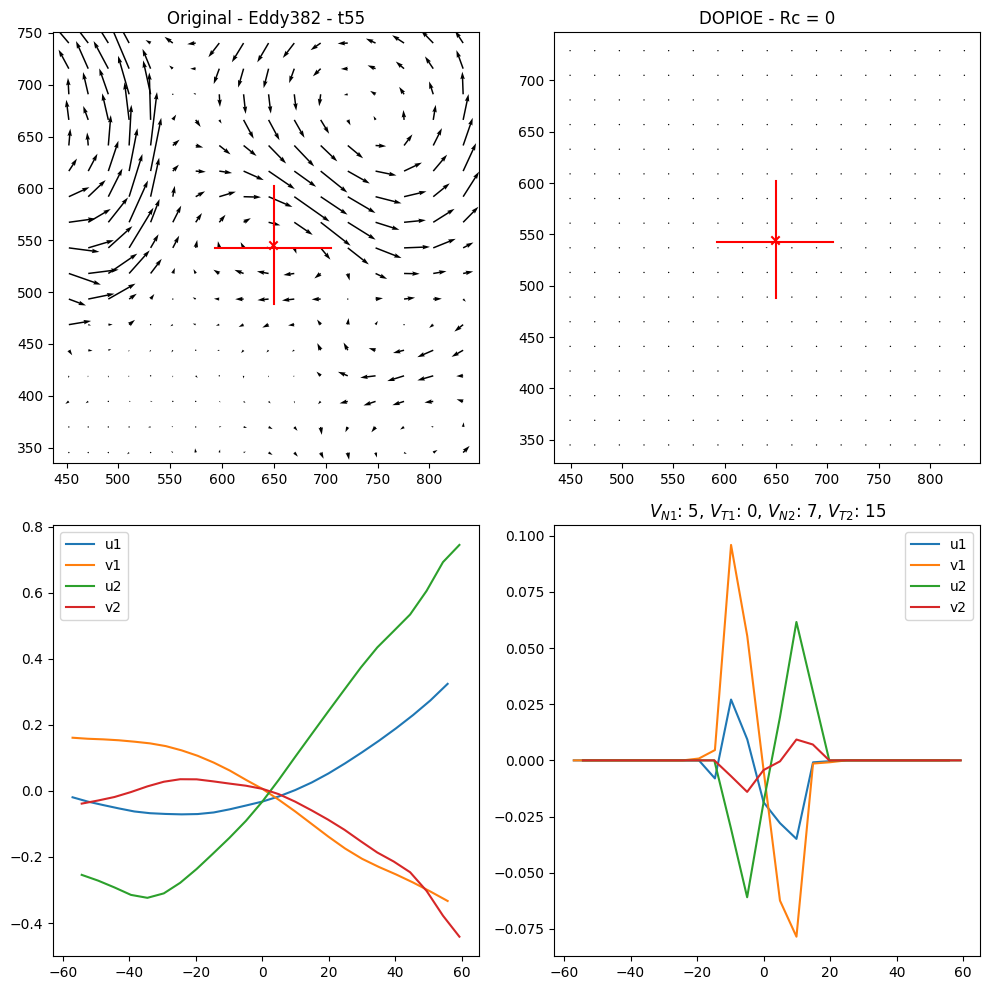

,Rc,Scale
$V_{N1}$,5.476462,28.161759
$V_{T1}$,0.340174,0.218393
$V_{N2}$,7.014512,51.988720
$V_{T2}$,15.000000,-273.783284


In [26]:
eddy = 382
t = 55

dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid)
ue = dic_eddy_domain['u']
ve = dic_eddy_domain['v']
Xe = dic_eddy_domain['X']
Ye = dic_eddy_domain['Y']
q11e = dic_eddy_domain['q11']
q12e = dic_eddy_domain['q12']
q22e = dic_eddy_domain['q22']
x0e = dic_eddy_domain['x0']
y0e = dic_eddy_domain['y0']
Depthe = dic_eddy_domain['Depth']

dic_eddy_transect = extract_transect_center(ue, ve, Xe, Ye, x0e, y0e, r=60)
x1e = dic_eddy_transect['x1']
y1e = dic_eddy_transect['y1']
u1e = dic_eddy_transect['u1']
v1e = dic_eddy_transect['v1']
xxe = dic_eddy_transect['xx']
x2e = dic_eddy_transect['x2']
y2e = dic_eddy_transect['y2']
u2e = dic_eddy_transect['u2']
v2e = dic_eddy_transect['v2']
yye = dic_eddy_transect['yy']

scale_VN1e, Rc_VN1e = fit_Rc_VN1(x1e, y1e, v1e, q11e, q12e, q22e, x0e, y0e)
scale_VT1e, Rc_VT1e = fit_Rc_VT1(x1e, y1e, u1e, q11e, q12e, q22e, x0e, y0e)

scale_VN2e, Rc_VN2e = fit_Rc_VN2(x2e, y2e, u2e, q11e, q12e, q22e, x0e, y0e)
scale_VT2e, Rc_VT2e = fit_Rc_VT2(x2e, y2e, v2e, q11e, q12e, q22e, x0e, y0e)

df_Rce = pd.DataFrame({'Rc': [Rc_VN1e, Rc_VT1e, Rc_VN2e, Rc_VT2e], 'Scale': [scale_VN1e, scale_VT1e, scale_VN2e, scale_VT2e]})
df_Rce.index = [r'$V_{N1}$', r'$V_{T1}$', r'$V_{N2}$', r'$V_{T2}$']
Rce = df_Rce[(df_Rce['Rc']!=15)&(df_Rce['Rc']!=1e-6)]['Rc'].min()

print("Optimal Rc =", Rce)
print("Optimal Scale =", df_Rce[df_Rce['Rc']==Rce]['Scale'])

# Recreate Eddy

u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rce)

u_dopioe, v_dopioe, u1_dopioe, v1_dopioe, u2_dopioe, v2_dopioe = vel_scalar(x1e, y1e, u1e, v1e, x2e, y2e, u2e, v2e, u_dopioe, v_dopioe, X_dopioe, Y_dopioe)


## PLOTTING

fig, axs = plt.subplots(2, 2, figsize=(10,10))
quive_scale = 10

spacing = 5
axs[0,0].quiver(Xe[::spacing, ::spacing], Ye[::spacing, ::spacing],
                ue[::spacing, ::spacing], ve[::spacing, ::spacing], scale=quive_scale)
axs[0,0].plot(x1e, y1e, 'r')
axs[0,0].plot(x2e, y2e, 'r')
axs[0,0].scatter(x0e, y0e, marker='x', color='r')
axs[0,0].axis('equal')
axs[0,0].set_title(f'Original - Eddy{eddy} - t{t}')

spacing = 3
axs[0,1].quiver(X_dopioe[::spacing, ::spacing], Y_dopioe[::spacing, ::spacing],
                u_dopioe[::spacing, ::spacing], v_dopioe[::spacing, ::spacing], scale=quive_scale)
axs[0,1].plot(x1e, y1e, 'r')
axs[0,1].plot(x2e, y2e, 'r')
axs[0,1].scatter(x0e, y0e, marker='x', color='r')
axs[0,1].axis('equal')
axs[0,1].set_title(f'DOPIOE - Rc = {round(Rce)}')

axs[1,0].plot(xxe, u1e, label='u1')
axs[1,0].plot(xxe, v1e, label='v1')
axs[1,0].plot(yye, u2e, label='u2')
axs[1,0].plot(yye, v2e, label='v2')
axs[1,0].legend()

axs[1,1].plot(xxe, u1_dopioe, label='u1')
axs[1,1].plot(xxe, v1_dopioe, label='v1')
axs[1,1].plot(yye, u2_dopioe, label='u2')
axs[1,1].plot(yye, v2_dopioe, label='v2')
axs[1,1].legend()
axs[1, 1].set_title(f"{df_Rce.index[0]}: {round(df_Rce.iloc[0]['Rc'])}, {df_Rce.index[1]}: {round(df_Rce.iloc[1]['Rc'])}, {df_Rce.index[2]}: {round(df_Rce.iloc[2]['Rc'])}, {df_Rce.index[3]}: {round(df_Rce.iloc[3]['Rc'])}")

plt.tight_layout()
plt.show()


df_Rce


In [27]:
sample_eddies

['Eddy2749',
 'Eddy8',
 'Eddy2504',
 'Eddy896',
 'Eddy1394',
 'Eddy382',
 'Eddy1967',
 'Eddy926']

In [28]:
for eddy in sample_eddies:
    eddy = int(eddy[4:])
    for t in [10, 20, 30, 40, 50]:

        dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid)
        ue = dic_eddy_domain['u']
        ve = dic_eddy_domain['v']
        Xe = dic_eddy_domain['X']
        Ye = dic_eddy_domain['Y']
        q11e = dic_eddy_domain['q11']
        q12e = dic_eddy_domain['q12']
        q22e = dic_eddy_domain['q22']
        x0e = dic_eddy_domain['x0']
        y0e = dic_eddy_domain['y0']
        Depthe = dic_eddy_domain['Depth']
    
        dic_eddy_transect = extract_transect_center(ue, ve, Xe, Ye, x0e, y0e, r=60)
        x1e = dic_eddy_transect['x1']
        y1e = dic_eddy_transect['y1']
        u1e = dic_eddy_transect['u1']
        v1e = dic_eddy_transect['v1']
        xxe = dic_eddy_transect['xx']
        x2e = dic_eddy_transect['x2']
        y2e = dic_eddy_transect['y2']
        u2e = dic_eddy_transect['u2']
        v2e = dic_eddy_transect['v2']
        yye = dic_eddy_transect['yy']
        
        scale_VN1e, Rc_VN1e = fit_Rc_VN1(x1e, y1e, v1e, q11e, q12e, q22e, x0e, y0e)
        scale_VT1e, Rc_VT1e = fit_Rc_VT1(x1e, y1e, u1e, q11e, q12e, q22e, x0e, y0e)
        
        scale_VN2e, Rc_VN2e = fit_Rc_VN2(x2e, y2e, u2e, q11e, q12e, q22e, x0e, y0e)
        scale_VT2e, Rc_VT2e = fit_Rc_VT2(x2e, y2e, v2e, q11e, q12e, q22e, x0e, y0e)
        
        df_Rce = pd.DataFrame({'Rc': [Rc_VN1e, Rc_VT1e, Rc_VN2e, Rc_VT2e], 'Scale': [scale_VN1e, scale_VT1e, scale_VN2e, scale_VT2e]})
        df_Rce.index = [r'$V_{N1}$', r'$V_{T1}$', r'$V_{N2}$', r'$V_{T2}$']
        Rce = df_Rce[(df_Rce['Rc']!=15)&(df_Rce['Rc']!=1e-6)]['Rc'].median()

        if not np.isnan(Rce):
            
            # Recreate Eddy
            
            u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rce)
            
            u_dopioe, v_dopioe, u1_dopioe, v1_dopioe, u2_dopioe, v2_dopioe = vel_scalar(x1e, y1e, u1e, v1e, x2e, y2e, u2e, v2e, u_dopioe, v_dopioe, X_dopioe, Y_dopioe)
        
        
        ## PLOTTING
        
        fig, axs = plt.subplots(2, 2, figsize=(10,10))
        quive_scale = 10
        
        spacing = 5
        axs[0,0].quiver(Xe[::spacing, ::spacing], Ye[::spacing, ::spacing],
                        ue[::spacing, ::spacing], ve[::spacing, ::spacing], scale=quive_scale)
        axs[0,0].plot(x1e, y1e, 'r')
        axs[0,0].plot(x2e, y2e, 'r')
        axs[0,0].scatter(x0e, y0e, marker='x', color='r')
        axs[0,0].axis('equal')
        axs[0,0].set_title(f'Original - Eddy{eddy} - t{t}')

        if not np.isnan(Rce):
        
            spacing = 3
            axs[0,1].quiver(X_dopioe[::spacing, ::spacing], Y_dopioe[::spacing, ::spacing],
                            u_dopioe[::spacing, ::spacing], v_dopioe[::spacing, ::spacing], scale=quive_scale)
            axs[0,1].plot(x1e, y1e, 'r')
            axs[0,1].plot(x2e, y2e, 'r')
            axs[0,1].scatter(x0e, y0e, marker='x', color='r')
            axs[0,1].axis('equal')
            axs[0,1].set_title(f'DOPIOE - Rc = {round(Rce)}')
            
            axs[1,0].plot(xxe, u1e, label='u1')
            axs[1,0].plot(xxe, v1e, label='v1')
            axs[1,0].plot(yye, u2e, label='u2')
            axs[1,0].plot(yye, v2e, label='v2')
            axs[1,0].legend()
            
            axs[1,1].plot(xxe, u1_dopioe, label='u1')
            axs[1,1].plot(xxe, v1_dopioe, label='v1')
            axs[1,1].plot(yye, u2_dopioe, label='u2')
            axs[1,1].plot(yye, v2_dopioe, label='v2')
            axs[1,1].legend()
            axs[1,1].set_title(f"{df_Rce.index[0]}: {round(df_Rce.iloc[0]['Rc'])}, {df_Rce.index[1]}: {round(df_Rce.iloc[1]['Rc'])}, {df_Rce.index[2]}: {round(df_Rce.iloc[2]['Rc'])}, {df_Rce.index[3]}: {round(df_Rce.iloc[3]['Rc'])}")
            
        plt.tight_layout()
        plt.savefig(f"/srv/scratch/z5297792/Chapter2/DOPIOE_Remodelling_Images/DOPIOE_Remodelled_Eddy{eddy}_t{t}.png", dpi=300, bbox_inches='tight')
        plt.close()
        print(eddy)


2749
2749
2749
Optimal Scale = -58.62828724506155
2749
Optimal Scale = -108.67815084073536
2749
Optimal Scale = -3248734102.5281687
8
8
8
Optimal Scale = -216.2225905499897
8
Optimal Scale = -157.86549971820108
8
Optimal Scale = -34.052721775895925
2504
Optimal Scale = -39.637361615554106
2504
Optimal Scale = -14.800584725500734
2504
Optimal Scale = -35.29978399805616
2504
Optimal Scale = -19.263340947973468
2504
Optimal Scale = -35.890632161216566
896
Optimal Scale = -94.57136291355684
896
Optimal Scale = -34.34862107347793
896
Optimal Scale = -30.77543978528348
896
Optimal Scale = -141.9036497040091
896
Optimal Scale = 71.49907122663936
1394
Optimal Scale = 2.5603706948101075
1394
Optimal Scale = 3.6363636393833554
1394
Optimal Scale = 43.751616007341326
1394
Optimal Scale = 82.62185502992838
1394
Optimal Scale = 46.85735213007107
382
Optimal Scale = 18.093481558269506
382
Optimal Scale = 18.5698472398316
382
Optimal Scale = 29.268162818170666
382
Optimal Scale = 28.980200574250574
3